In [1]:
!pip install openml pandas


zsh:1: command not found: pip


In [4]:
import sys
!{sys.executable} -m pip install openml pandas


Defaulting to user installation because normal site-packages is not writeable


In [5]:
import pandas as pd
import openml

print("Libraries installed and working!")


/Users/damiza/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Libraries installed and working!


In [6]:
import openml
import pandas as pd

# Load dataset from OpenML
dataset = openml.datasets.get_dataset(45072)
df, *_ = dataset.get_data()

# Quick look at the first 5 rows
df.head()


,Flight,Time,Length,Airline,AirportFrom,AirportTo,DayOfWeek,class
0,2774.0,1235.0,80.0,MQ,DFW,CRP,5,0
1,2313.0,1296.0,141.0,DL,ATL,HOU,1,0
2,6948.0,360.0,146.0,OO,COS,ORD,4,0
3,1247.0,1170.0,143.0,B6,BOS,CLT,3,0
4,31.0,1410.0,344.0,US,OGG,PHX,6,0


In [7]:
df.to_csv("my_dataset.csv", index=False)
print("Dataset saved locally as my_dataset.csv")


Dataset saved locally as my_dataset.csv


In [8]:
# Check number of rows and columns
print("Dataset shape:", df.shape)

# Check column types and missing values
print(df.info())

# Quick summary of numeric columns
print(df.describe())


Dataset shape: (539383, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539383 entries, 0 to 539382
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype   
---  ------       --------------   -----   
 0   Flight       539383 non-null  float64 
 1   Time         539383 non-null  float64 
 2   Length       539383 non-null  float64 
 3   Airline      539383 non-null  category
 4   AirportFrom  539383 non-null  category
 5   AirportTo    539383 non-null  category
 6   DayOfWeek    539383 non-null  category
 7   class        539383 non-null  uint8   
dtypes: category(4), float64(3), uint8(1)
memory usage: 16.0 MB
None
              Flight           Time         Length          class
count  539383.000000  539383.000000  539383.000000  539383.000000
mean     2427.928630     802.728963     132.202007       0.445442
std      2067.429837     278.045911      70.117016       0.497015
min         1.000000      10.000000       0.000000       0.000000
25%       712.000000    

In [10]:
import pandas as pd
import numpy as np

# Suppose you have loaded your data already:
# df = …

# 1. Quick overview
print("Original shape:", df.shape)
print(df.info())
print(df.head())

# 2. Drop irrelevant/unnecessary columns (example — adjust based on your dataset)
cols_to_drop = [
    # example column names — change these to ones in your dataset
    # e.g. flight ID, tail number, unsued timestamps, etc
    'TailNum', 'FlightNum', 'CancellationCode', 'DivTime', 'TaxiIn', 'TaxiOut'
]
df = df.drop(columns=[c for c in cols_to_drop if c in df.columns], errors='ignore')

# 3. Handle missing values
# Example strategy for delay‑reason columns if you have columns like CarrierDelay, WeatherDelay etc
delay_reason_cols = ['CarrierDelay','WeatherDelay','NASDelay','SecurityDelay','LateAircraftDelay']
for c in delay_reason_cols:
    if c in df.columns:
        df[c] = df[c].fillna(0)  # assume missing = 0 delay from that reason

# For numeric columns: you can impute median (or drop rows if missing small portion)
numeric_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
for c in numeric_cols:
    df[c] = df[c].fillna(df[c].median())

# For categorical columns: fill missing with 'Unknown' or mode
cat_cols = df.select_dtypes(include=['object','category']).columns.tolist()
for c in cat_cols:
    df[c] = df[c].fillna('Unknown')

# 4. Remove duplicate rows (if any)
df = df.drop_duplicates()

# 5. Convert times/dates if needed
if all(col in df.columns for col in ['Year','Month','DayOfMonth']):
    df['FlightDate'] = pd.to_datetime(
        df[['Year','Month','DayOfMonth']].rename(columns={'Year':'year','Month':'month','DayOfMonth':'day'})
    )
    df = df.drop(columns=['Year','Month','DayOfMonth'])

# If scheduled/actual times are in HHMM or integer format (e.g. 2350 for 23:50), convert:
def convert_hhmm(x):
    try:
        x = int(x)
        hh = x // 100
        mm = x % 100
        return hh * 60 + mm  # convert to minutes since midnight
    except:
        return np.nan

for time_col in ['CRS_DEP_TIME','DEP_TIME','CRS_ARR_TIME','ARR_TIME']:
    if time_col in df.columns:
        df[time_col+'_mins'] = df[time_col].apply(convert_hhmm)
        # drop original if you like
        # df = df.drop(columns=[time_col])

# 6. (Optional) Create target variable for classification
if 'ArrDelay' in df.columns:
    df['Delayed'] = (df['ArrDelay'] > 15).astype(int)  # flights delayed > 15 min

# 7. Encode categorical variables (One‑Hot or similar)
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# 8. Final check
print("Cleaned shape:", df.shape)
print(df.isna().sum().sum(), " total missing values remain")

# Get all categorical columns
cat_cols = df.select_dtypes(include=['category']).columns.tolist()

for c in cat_cols:
    # Add 'Unknown' to categories first
    df[c] = df[c].cat.add_categories(['Unknown'])
    # Then fill missing values
    df[c] = df[c].fillna('Unknown')


Original shape: (539383, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539383 entries, 0 to 539382
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype   
---  ------       --------------   -----   
 0   Flight       539383 non-null  float64 
 1   Time         539383 non-null  float64 
 2   Length       539383 non-null  float64 
 3   Airline      539383 non-null  category
 4   AirportFrom  539383 non-null  category
 5   AirportTo    539383 non-null  category
 6   DayOfWeek    539383 non-null  category
 7   class        539383 non-null  uint8   
dtypes: category(4), float64(3), uint8(1)
memory usage: 16.0 MB
None
   Flight    Time  Length Airline AirportFrom AirportTo DayOfWeek  class
0  2774.0  1235.0    80.0      MQ         DFW       CRP         5      0
1  2313.0  1296.0   141.0      DL         ATL       HOU         1      0
2  6948.0   360.0   146.0      OO         COS       ORD         4      0
3  1247.0  1170.0   143.0      B6         BOS       CLT      

TypeError: Cannot setitem on a Categorical with a new category (Unknown), set the categories first

In [11]:
import pandas as pd
import numpy as np

# Suppose you have loaded your data already:
# df = …

# 1. Quick overview
print("Original shape:", df.shape)
print(df.info())
print(df.head())

# 2. Drop irrelevant/unnecessary columns (example — adjust based on your dataset)
cols_to_drop = [
    # example column names — change these to ones in your dataset
    # e.g. flight ID, tail number, unsued timestamps, etc
    'TailNum', 'FlightNum', 'CancellationCode', 'DivTime', 'TaxiIn', 'TaxiOut'
]
df = df.drop(columns=[c for c in cols_to_drop if c in df.columns], errors='ignore')

# 3. Handle missing values
# Example strategy for delay‑reason columns if you have columns like CarrierDelay, WeatherDelay etc
delay_reason_cols = ['CarrierDelay','WeatherDelay','NASDelay','SecurityDelay','LateAircraftDelay']
for c in delay_reason_cols:
    if c in df.columns:
        df[c] = df[c].fillna(0)  # assume missing = 0 delay from that reason

# For numeric columns: you can impute median (or drop rows if missing small portion)
numeric_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
for c in numeric_cols:
    df[c] = df[c].fillna(df[c].median())

# For categorical columns: fill missing with 'Unknown' or mode
cat_cols = df.select_dtypes(include=['object','category']).columns.tolist()
for c in cat_cols:
    df[c] = df[c].fillna('Unknown')

# 4. Remove duplicate rows (if any)
df = df.drop_duplicates()

# 5. Convert times/dates if needed
if all(col in df.columns for col in ['Year','Month','DayOfMonth']):
    df['FlightDate'] = pd.to_datetime(
        df[['Year','Month','DayOfMonth']].rename(columns={'Year':'year','Month':'month','DayOfMonth':'day'})
    )
    df = df.drop(columns=['Year','Month','DayOfMonth'])

# If scheduled/actual times are in HHMM or integer format (e.g. 2350 for 23:50), convert:
def convert_hhmm(x):
    try:
        x = int(x)
        hh = x // 100
        mm = x % 100
        return hh * 60 + mm  # convert to minutes since midnight
    except:
        return np.nan

for time_col in ['CRS_DEP_TIME','DEP_TIME','CRS_ARR_TIME','ARR_TIME']:
    if time_col in df.columns:
        df[time_col+'_mins'] = df[time_col].apply(convert_hhmm)
        # drop original if you like
        # df = df.drop(columns=[time_col])

# 6. (Optional) Create target variable for classification
if 'ArrDelay' in df.columns:
    df['Delayed'] = (df['ArrDelay'] > 15).astype(int)  # flights delayed > 15 min

# 7. Encode categorical variables (One‑Hot or similar)
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# 8. Final check
print("Cleaned shape:", df.shape)
print(df.isna().sum().sum(), " total missing values remain")

# Get all categorical columns
cat_cols = df.select_dtypes(include=['category']).columns.tolist()

for c in cat_cols:
    # Add 'Unknown' to categories first
    df[c] = df[c].cat.add_categories(['Unknown'])
    # Then fill missing values
    df[c] = df[c].fillna('Unknown')


Original shape: (539383, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539383 entries, 0 to 539382
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype   
---  ------       --------------   -----   
 0   Flight       539383 non-null  float64 
 1   Time         539383 non-null  float64 
 2   Length       539383 non-null  float64 
 3   Airline      539383 non-null  category
 4   AirportFrom  539383 non-null  category
 5   AirportTo    539383 non-null  category
 6   DayOfWeek    539383 non-null  category
 7   class        539383 non-null  uint8   
dtypes: category(4), float64(3), uint8(1)
memory usage: 16.0 MB
None
   Flight    Time  Length Airline AirportFrom AirportTo DayOfWeek  class
0  2774.0  1235.0    80.0      MQ         DFW       CRP         5      0
1  2313.0  1296.0   141.0      DL         ATL       HOU         1      0
2  6948.0   360.0   146.0      OO         COS       ORD         4      0
3  1247.0  1170.0   143.0      B6         BOS       CLT      

TypeError: Cannot setitem on a Categorical with a new category (Unknown), set the categories first

In [12]:
# Get all categorical columns
cat_cols = df.select_dtypes(include=['category']).columns.tolist()

for c in cat_cols:
    # Add 'Unknown' as a valid category first
    df[c] = df[c].cat.add_categories(['Unknown'])
    # Now fill missing values
    df[c] = df[c].fillna('Unknown')

# Verify
print(df[cat_cols].isna().sum())


Airline        0
AirportFrom    0
AirportTo      0
DayOfWeek      0
dtype: int64


In [13]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Suppose your dataset is already loaded as df
# df = ... (your OpenML dataset)

# 1. Quick overview
print("Original shape:", df.shape)
print(df.info())
print(df.head())

# 2. Handle missing numeric columns (fill with median)
numeric_cols = df.select_dtypes(include=['float64','int64']).columns.tolist()
for c in numeric_cols:
    df[c] = df[c].fillna(df[c].median())

# 3. Handle missing categorical columns safely
cat_cols = df.select_dtypes(include=['category']).columns.tolist()
for c in cat_cols:
    df[c] = df[c].cat.add_categories(['Unknown'])  # Add 'Unknown' as a valid category
    df[c] = df[c].fillna('Unknown')                # Fill missing values

# 4. Remove duplicate rows
df = df.drop_duplicates()

# 5. One-hot encode categorical variables
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# 6. Scale numeric features
scaler = StandardScaler()
numeric_cols = ['Flight','Time','Length']  # adjust if needed
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# 7. Split into features X and target y
# 'class' is the target
X = df.drop(columns=['class'])
y = df['class']

# 8. Quick check
print("Cleaned shape:", df.shape)
print("Features shape:", X.shape)
print("Target shape:", y.shape)
print("Any missing values left?", df.isna().sum().sum())


Original shape: (539383, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539383 entries, 0 to 539382
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype   
---  ------       --------------   -----   
 0   Flight       539383 non-null  float64 
 1   Time         539383 non-null  float64 
 2   Length       539383 non-null  float64 
 3   Airline      539383 non-null  category
 4   AirportFrom  539383 non-null  category
 5   AirportTo    539383 non-null  category
 6   DayOfWeek    539383 non-null  category
 7   class        539383 non-null  uint8   
dtypes: category(4), float64(3), uint8(1)
memory usage: 16.0 MB
None
   Flight    Time  Length Airline AirportFrom AirportTo DayOfWeek  class
0  2774.0  1235.0    80.0      MQ         DFW       CRP         5      0
1  2313.0  1296.0   141.0      DL         ATL       HOU         1      0
2  6948.0   360.0   146.0      OO         COS       ORD         4      0
3  1247.0  1170.0   143.0      B6         BOS       CLT      

ValueError: new categories must not include old categories: {'Unknown'}

In [14]:
# Get all categorical columns
cat_cols = df.select_dtypes(include=['category']).columns.tolist()

for c in cat_cols:
    # Only add 'Unknown' if it is NOT already a category
    if 'Unknown' not in df[c].cat.categories:
        df[c] = df[c].cat.add_categories(['Unknown'])
    # Fill missing values
    df[c] = df[c].fillna('Unknown')

# Verify
print(df[cat_cols].isna().sum())


Airline        0
AirportFrom    0
AirportTo      0
DayOfWeek      0
dtype: int64


In [15]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# -----------------------------
# 1. Quick overview
# -----------------------------
print("Original shape:", df.shape)
print(df.info())
print(df.head())

# -----------------------------
# 2. Handle missing numeric columns
# -----------------------------
numeric_cols = df.select_dtypes(include=['float64','int64']).columns.tolist()
for c in numeric_cols:
    df[c] = df[c].fillna(df[c].median())

# -----------------------------
# 3. Handle categorical columns safely
# -----------------------------
cat_cols = df.select_dtypes(include=['category']).columns.tolist()
for c in cat_cols:
    # Only add 'Unknown' if it is not already a category
    if 'Unknown' not in df[c].cat.categories:
        df[c] = df[c].cat.add_categories(['Unknown'])
    # Fill missing values
    df[c] = df[c].fillna('Unknown')

# Verify no missing values in categorical columns
print("Missing values in categorical columns:")
print(df[cat_cols].isna().sum())

# -----------------------------
# 4. Remove duplicate rows
# -----------------------------
df = df.drop_duplicates()
print("Shape after removing duplicates:", df.shape)

# -----------------------------
# 5. One-hot encode categorical variables
# -----------------------------
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# -----------------------------
# 6. Scale numeric features
# -----------------------------
scaler = StandardScaler()
numeric_cols = ['Flight','Time','Length']  # adjust if needed
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# -----------------------------
# 7. Split into features X and target y
# -----------------------------
# 'class' is the target
X = df.drop(columns=['class'])
y = df['class']

# -----------------------------
# 8. Final checks
# -----------------------------
print("Cleaned dataframe shape:", df.shape)
print("Features shape:", X.shape)
print("Target shape:", y.shape)
print("Any missing values left?", df.isna().sum().sum())


Original shape: (539383, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539383 entries, 0 to 539382
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype   
---  ------       --------------   -----   
 0   Flight       539383 non-null  float64 
 1   Time         539383 non-null  float64 
 2   Length       539383 non-null  float64 
 3   Airline      539383 non-null  category
 4   AirportFrom  539383 non-null  category
 5   AirportTo    539383 non-null  category
 6   DayOfWeek    539383 non-null  category
 7   class        539383 non-null  uint8   
dtypes: category(4), float64(3), uint8(1)
memory usage: 16.0 MB
None
   Flight    Time  Length Airline AirportFrom AirportTo DayOfWeek  class
0  2774.0  1235.0    80.0      MQ         DFW       CRP         5      0
1  2313.0  1296.0   141.0      DL         ATL       HOU         1      0
2  6948.0   360.0   146.0      OO         COS       ORD         4      0
3  1247.0  1170.0   143.0      B6         BOS       CLT      

In [16]:
# -----------------------------
# ML Modeling
# -----------------------------
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 1. Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 2. Initialize models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, n_jobs=-1),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    "XGBoost": XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# 3. Train and evaluate each model
for name, model in models.items():
    print(f"\n--- {name} ---")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")


ModuleNotFoundError: No module named 'xgboost'

In [17]:
!pip install xgboost


Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 34.2 MB/s  0:00:00


In [18]:
# -----------------------------
# ML Modeling
# -----------------------------
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 1. Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 2. Initialize models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, n_jobs=-1),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    "XGBoost": XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# 3. Train and evaluate each model
for name, model in models.items():
    print(f"\n--- {name} ---")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")


XGBoostError: 
XGBoost Library (libxgboost.dylib) could not be loaded.
Likely causes:
  * OpenMP runtime is not installed
    - vcomp140.dll or libgomp-1.dll for Windows
    - libomp.dylib for Mac OSX
    - libgomp.so for Linux and other UNIX-like OSes
    Mac OSX users: Run `brew install libomp` to install OpenMP runtime.

  * You are running 32-bit Python on a 64-bit OS

Error message(s): ["dlopen(/Users/damiza/Library/Python/3.9/lib/python/site-packages/xgboost/lib/libxgboost.dylib, 0x0006): Library not loaded: @rpath/libomp.dylib\n  Referenced from: <89AD948E-E564-3266-867D-7AF89D6488F0> /Users/damiza/Library/Python/3.9/lib/python/site-packages/xgboost/lib/libxgboost.dylib\n  Reason: tried: '/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file)"]


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 1. Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 2. Initialize models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, n_jobs=-1),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    "XGBoost": XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# 3. Train and evaluate each model
for name, model in models.items():
    print(f"\n--- {name} ---")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")


XGBoostError: 
XGBoost Library (libxgboost.dylib) could not be loaded.
Likely causes:
  * OpenMP runtime is not installed
    - vcomp140.dll or libgomp-1.dll for Windows
    - libomp.dylib for Mac OSX
    - libgomp.so for Linux and other UNIX-like OSes
    Mac OSX users: Run `brew install libomp` to install OpenMP runtime.

  * You are running 32-bit Python on a 64-bit OS

Error message(s): ["dlopen(/Users/damiza/Library/Python/3.9/lib/python/site-packages/xgboost/lib/libxgboost.dylib, 0x0006): Library not loaded: @rpath/libomp.dylib\n  Referenced from: <89AD948E-E564-3266-867D-7AF89D6488F0> /Users/damiza/Library/Python/3.9/lib/python/site-packages/xgboost/lib/libxgboost.dylib\n  Reason: tried: '/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file)"]


In [20]:
brew install libomp


SyntaxError: invalid syntax (1568185342.py, line 1)

In [21]:
!pip uninstall xgboost

Found existing installation: xgboost 2.1.4
Uninstalling xgboost-2.1.4:
  Would remove:
    /Users/damiza/Library/Python/3.9/lib/python/site-packages/xgboost-2.1.4.dist-info/*
    /Users/damiza/Library/Python/3.9/lib/python/site-packages/xgboost/*
Proceed (Y/n)? ^C


In [22]:
Y

NameError: name 'Y' is not defined

In [23]:
!pip install xgboost

Defaulting to user installation because normal site-packages is not writeable


In [1]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 1. Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 2. Initialize models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, n_jobs=-1),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    "XGBoost": XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# 3. Train and evaluate each model
for name, model in models.items():
    print(f"\n--- {name} ---")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")


NameError: name 'X' is not defined

In [2]:
# Split into features X and target y
X = df.drop(columns=['class'])
y = df['class']


NameError: name 'df' is not defined

In [3]:
# Step 0 — Load dataset from OpenML
import openml
import pandas as pd

# Download the dataset (replace ID with the OpenML dataset ID for Airline Delay)
dataset_id = 23512  # Example: Airline Delay dataset
dataset = openml.datasets.get_dataset(dataset_id, download_all_files=True)

# Convert to pandas DataFrame
df, *_ = dataset.get_data()
print("Original shape:", df.shape)
print(df.head())
print(df.info())


/Users/damiza/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/var/folders/cy/kwx37bwd3fd2_dh6574sjn5r0000gn/T/ipykernel_1287/189258728.py:7: FutureWarning: ``download_all_files`` is experimental and is likely to break with new releases.
  dataset = openml.datasets.get_dataset(dataset_id, download_all_files=True)


Original shape: (98050, 29)
  class  lepton_pT  lepton_eta  lepton_phi  missing_energy_magnitude  \
0     1   0.907542    0.329147    0.359412                  1.497970   
1     1   0.798835    1.470639   -1.635975                  0.453773   
2     0   1.344385   -0.876626    0.935913                  1.992050   
3     1   1.105009    0.321356    1.522401                  0.882808   
4     0   1.595839   -0.607811    0.007075                  1.818450   

   missing_energy_phi    jet1pt   jet1eta   jet1phi  jet1b-tag  ...   jet4eta  \
0           -0.313010  1.095531 -0.557525 -1.588230   2.173076  ... -1.138930   
1            0.425629  1.104875  1.282322  1.381664   0.000000  ...  1.128848   
2            0.882454  1.786066 -1.646778 -0.942383   0.000000  ... -0.678379   
3           -1.205349  0.681466 -1.070464 -0.921871   0.000000  ... -0.373566   
4           -0.111906  0.847550 -0.566437  1.581239   2.173076  ... -0.654227   

    jet4phi  jet4b-tag      m_jj     m_jjj      m_lv

In [4]:
# Step 1 — Preprocessing
X = df.drop(columns=['class'])
y = df['class']
# ... plus the rest of the preprocessing code


In [5]:
print(X.shape)
print(y.shape)


(98050, 28)
(98050,)


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, n_jobs=-1),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
}

# Train and evaluate each model
for name, model in models.items():
    print(f"\n--- {name} ---")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")



--- Logistic Regression ---


ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [7]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# 1. Impute missing numeric values with median
num_cols = X.select_dtypes(include=['float64', 'int64']).columns
num_imputer = SimpleImputer(strategy='median')
X[num_cols] = num_imputer.fit_transform(X[num_cols])

# 2. Impute missing categorical values with 'Unknown'
cat_cols = X.select_dtypes(include=['category', 'object']).columns
for c in cat_cols:
    X[c] = X[c].cat.add_categories(['Unknown']) if 'Unknown' not in X[c].cat.categories else X[c]
    X[c] = X[c].fillna('Unknown')

# 3. One-hot encode categorical variables
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

# 4. Scale numeric features (optional but helps Logistic Regression)
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

# Check for any remaining NaNs
print("Any missing values left?", X.isna().sum().sum())


Any missing values left? 0


In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 1. Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 2. Initialize models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, n_jobs=-1),  # basic linear classifier
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)  # ensemble of decision trees
}



# 3. Train and evaluate each model
for name, model in models.items():
    print(f"\n--- {name} ---")
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Evaluate performance
    acc = accuracy_score(y_test, y_pred)      # accuracy
    prec = precision_score(y_test, y_pred)    # proportion of true positives among predicted positives
    rec = recall_score(y_test, y_pred)        # proportion of true positives among actual positives
    f1 = f1_score(y_test, y_pred)             # harmonic mean of precision and recall
    
    # Print metrics
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")



--- Logistic Regression ---


ValueError: pos_label=1 is not a valid label. It should be one of ['0', '1']

In [9]:
# Convert target to numeric
y = y.astype(int)

# Split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 1. Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 2. Initialize models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, n_jobs=-1),  # basic linear classifier
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)  # ensemble of decision trees
}


# 3. Train and evaluate each model
for name, model in models.items():
    print(f"\n--- {name} ---")
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Evaluate performance
    acc = accuracy_score(y_test, y_pred)      # overall accuracy
    prec = precision_score(y_test, y_pred)    # proportion of true positives among predicted positives
    rec = recall_score(y_test, y_pred)        # proportion of true positives among actual positives
    f1 = f1_score(y_test, y_pred)             # harmonic mean of precision and recall
    
    # Print metrics
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")



--- Logistic Regression ---
Accuracy : 0.6384
Precision: 0.6356
Recall   : 0.7406
F1-score : 0.6841

--- Random Forest ---
Accuracy : 0.7163
Precision: 0.7299
Recall   : 0.7354
F1-score : 0.7326


In [11]:

from sklearn.model_selection import GridSearchCV

# 1. Logistic Regression hyperparameters
lr_params = {
    'C': [0.01, 0.1, 1, 10],       # Regularization strength
    'solver': ['liblinear', 'saga'] # Solvers suitable for small and large datasets
}

lr_grid = GridSearchCV(
    LogisticRegression(max_iter=1000, n_jobs=-1),
    lr_params,
    cv=3,                # 3-fold cross-validation
    scoring='f1',        # Optimize for F1-score
    n_jobs=-1
)

lr_grid.fit(X_train, y_train)
print("Best Logistic Regression params:", lr_grid.best_params_)
print("Best F1-score:", lr_grid.best_score_)

# 2. Random Forest hyperparameters
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    rf_params,
    cv=3,
    scoring='f1',
    n_jobs=-1
)

rf_grid.fit(X_train, y_train)
print("\nBest Random Forest params:", rf_grid.best_params_)
print("Best F1-score:", rf_grid.best_score_)

# 3. Evaluate tuned models on test set
best_lr = lr_grid.best_estimator_
best_rf = rf_grid.best_estimator_

for name, model in [("Tuned Logistic Regression", best_lr),
                    ("Tuned Random Forest", best_rf)]:
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f"\n{name} performance on test set:")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")


/Users/damiza/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/damiza/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/damiza/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/damiza/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/damiza/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jo

Best Logistic Regression params: {'C': 10, 'solver': 'liblinear'}
Best F1-score: 0.6865429608985214


KeyboardInterrupt: 

In [12]:
# -----------------------------
# Step 3 — Fast Hyperparameter Tuning
# -----------------------------
from sklearn.model_selection import GridSearchCV

# Use a smaller subset for tuning to save time
X_small = X_train.sample(n=50000, random_state=42)
y_small = y_train.loc[X_small.index]

# 1. Logistic Regression (faster tuning)
lr_params = {
    'C': [1, 10],            # smaller grid
    'solver': ['liblinear']   # use only liblinear for stability
}

lr_grid = GridSearchCV(
    LogisticRegression(max_iter=1000),
    lr_params,
    cv=3,
    scoring='f1',
    n_jobs=-1
)

lr_grid.fit(X_small, y_small)
print("Best Logistic Regression params:", lr_grid.best_params_)
print("Best F1-score:", lr_grid.best_score_)

# 2. Random Forest (faster tuning)
rf_params = {
    'n_estimators': [100],      # single value
    'max_depth': [10, 20],      # 2 options
    'min_samples_split': [2],   # single value
    'min_samples_leaf': [1]     # single value
}

rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    rf_params,
    cv=3,
    scoring='f1',
    n_jobs=-1
)

rf_grid.fit(X_small, y_small)
print("\nBest Random Forest params:", rf_grid.best_params_)
print("Best F1-score:", rf_grid.best_score_)

# 3. Evaluate tuned models on full test set
best_lr = lr_grid.best_estimator_
best_rf = rf_grid.best_estimator_

for name, model in [("Tuned Logistic Regression", best_lr),
                    ("Tuned Random Forest", best_rf)]:
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f"\n{name} performance on test set:")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")


Best Logistic Regression params: {'C': 10, 'solver': 'liblinear'}
Best F1-score: 0.6844428994950168

Best Random Forest params: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best F1-score: 0.7314063393491121

Tuned Logistic Regression performance on test set:
Accuracy : 0.6389
Precision: 0.6360
Recall   : 0.7409
F1-score : 0.6844

Tuned Random Forest performance on test set:
Accuracy : 0.7130
Precision: 0.7221
Recall   : 0.7428
F1-score : 0.7323


In [13]:
!pip install lightgbm


Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.0 MB/s  0:00:00


In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb  # LightGBM library


In [15]:
# Assuming your dataframe is 'df' and target column is 'class'
X = df.drop(columns=['class'])  # Features
y = df['class']                 # Target


In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [17]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, solver='liblinear'),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "LightGBM": lgb.LGBMClassifier(n_estimators=100, random_state=42)
}


In [18]:
for name, model in models.items():
    print(f"\n--- {name} ---")
    model.fit(X_train, y_train)        # Train model
    y_pred = model.predict(X_test)     # Predict on test set
    
    # Evaluation metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1-score: {f1:.4f}")



--- Logistic Regression ---


ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [19]:
# Fill numeric columns with median
num_cols = X.select_dtypes(include=['float64', 'int64']).columns
X[num_cols] = X[num_cols].fillna(X[num_cols].median())

# Fill categorical columns with mode
cat_cols = X.select_dtypes(include=['category']).columns
for c in cat_cols:
    X[c] = X[c].cat.add_categories(['Unknown'])  # make 'Unknown' a valid category
    X[c] = X[c].fillna('Unknown')


In [20]:
X = pd.get_dummies(X, drop_first=True)  # One-hot encode categories


In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, solver='liblinear'),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "LightGBM": lgb.LGBMClassifier(n_estimators=100, random_state=42)
}

for name, model in models.items():
    print(f"\n--- {name} ---")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1-score: {f1:.4f}")



--- Logistic Regression ---


ValueError: pos_label=1 is not a valid label. It should be one of ['0', '1']

In [23]:
# Convert target to integers
y = y.astype(int)


In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, solver='liblinear'),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "LightGBM": lgb.LGBMClassifier(n_estimators=100, random_state=42)
}

for name, model in models.items():
    print(f"\n--- {name} ---")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1-score: {f1:.4f}")



--- Logistic Regression ---
Accuracy: 0.6386, Precision: 0.6357, Recall: 0.7404, F1-score: 0.6841

--- Random Forest ---
Accuracy: 0.7163, Precision: 0.7299, Recall: 0.7353, F1-score: 0.7326

--- LightGBM ---
[LightGBM] [Info] Number of positive: 41462, number of negative: 36978
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001918 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6132
[LightGBM] [Info] Number of data points in the train set: 78440, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.528582 -> initscore=0.114454
[LightGBM] [Info] Start training from score 0.114454
Accuracy: 0.7241, Precision: 0.7354, Recall: 0.7466, F1-score: 0.7410


In [26]:
# -----------------------------
# Hyperparameter Tuning & Feature Importance
# -----------------------------

from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import pandas as pd

# -----------------------------
# 1. Random Forest Hyperparameter Tuning
# -----------------------------
rf_params = {
    'n_estimators': [100, 200],           # number of trees
    'max_depth': [None, 10, 20],          # max depth of each tree
    'min_samples_split': [2, 5],          # min samples required to split
    'min_samples_leaf': [1, 2]            # min samples at a leaf node
}

rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    rf_params,
    cv=3,        # 3-fold cross-validation
    scoring='f1', # optimize for F1-score
    verbose=1
)

rf_grid.fit(X_train, y_train)

print("Best Random Forest params:", rf_grid.best_params_)
print("Best F1-score:", rf_grid.best_score_)

# Feature importance for Random Forest
rf_best = rf_grid.best_estimator_
importances = rf_best.feature_importances_
feat_names = X_train.columns

# Plot feature importance
plt.figure(figsize=(12,6))
plt.barh(feat_names, importances)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Random Forest Feature Importance")
plt.show()

# -----------------------------
# 2. LightGBM Hyperparameter Tuning
# -----------------------------
lgb_params = {
    'num_leaves': [31, 50],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [100, 200],
    'max_depth': [5, 10, -1]
}

lgb_grid = GridSearchCV(
    lgb.LGBMClassifier(random_state=42),
    lgb_params,
    cv=3,
    scoring='f1',
    verbose=1
)

lgb_grid.fit(X_train, y_train)

print("Best LightGBM params:", lgb_grid.best_params_)
print("Best F1-score:", lgb_grid.best_score_)

# Feature importance for LightGBM
lgb_best = lgb_grid.best_estimator_
lgb_feat_importances = pd.Series(lgb_best.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Plot LightGBM feature importance
plt.figure(figsize=(12,6))
lgb_feat_importances.plot(kind='bar')
plt.title("LightGBM Feature Importance")
plt.show()


ModuleNotFoundError: No module named 'matplotlib'

In [27]:
!pip install matplotlib


Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 28.7 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 18.6 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 33.6 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8/8 [matplotlib]8 [matplotlib]


Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best Random Forest params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best F1-score: 0.7371960779114229


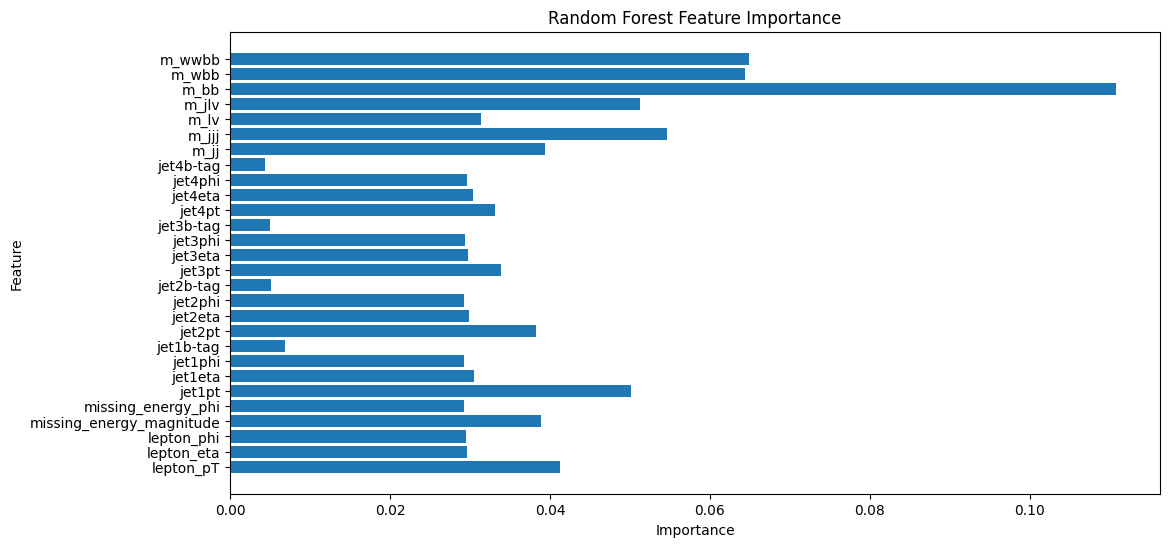

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[LightGBM] [Info] Number of positive: 27641, number of negative: 24652
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001031 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6132
[LightGBM] [Info] Number of data points in the train set: 52293, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.528579 -> initscore=0.114442
[LightGBM] [Info] Start training from score 0.114442
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

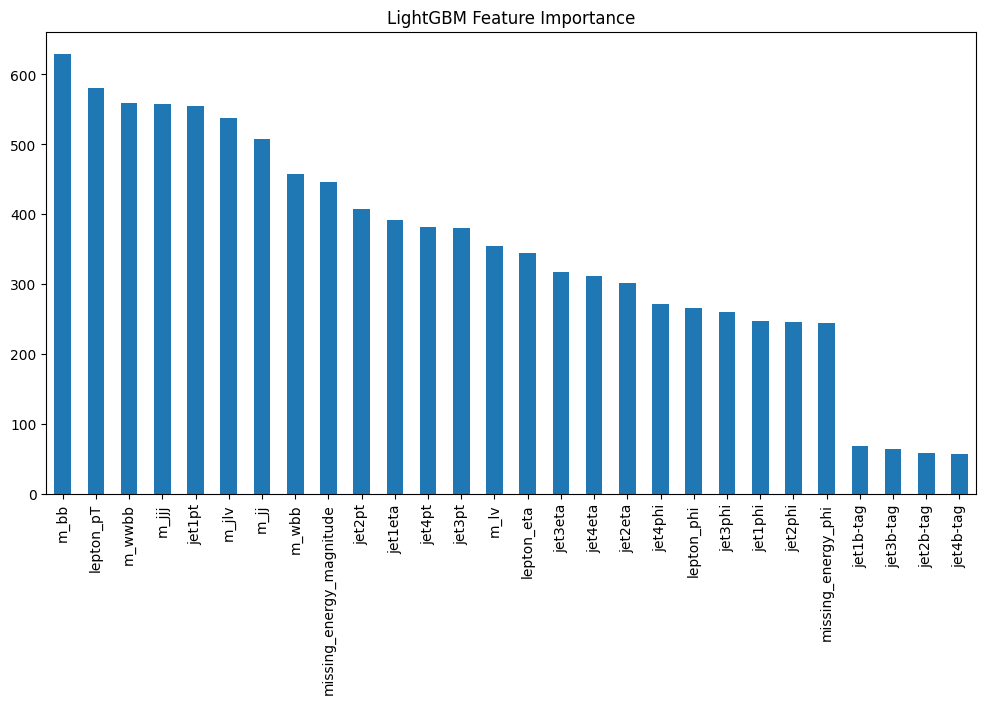

In [28]:
# -----------------------------
# Hyperparameter Tuning & Feature Importance
# -----------------------------

from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import pandas as pd

# -----------------------------
# 1. Random Forest Hyperparameter Tuning
# -----------------------------
rf_params = {
    'n_estimators': [100, 200],           # number of trees
    'max_depth': [None, 10, 20],          # max depth of each tree
    'min_samples_split': [2, 5],          # min samples required to split
    'min_samples_leaf': [1, 2]            # min samples at a leaf node
}

rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    rf_params,
    cv=3,        # 3-fold cross-validation
    scoring='f1', # optimize for F1-score
    verbose=1
)

rf_grid.fit(X_train, y_train)

print("Best Random Forest params:", rf_grid.best_params_)
print("Best F1-score:", rf_grid.best_score_)

# Feature importance for Random Forest
rf_best = rf_grid.best_estimator_
importances = rf_best.feature_importances_
feat_names = X_train.columns

# Plot feature importance
plt.figure(figsize=(12,6))
plt.barh(feat_names, importances)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Random Forest Feature Importance")
plt.show()

# -----------------------------
# 2. LightGBM Hyperparameter Tuning
# -----------------------------
lgb_params = {
    'num_leaves': [31, 50],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [100, 200],
    'max_depth': [5, 10, -1]
}

lgb_grid = GridSearchCV(
    lgb.LGBMClassifier(random_state=42),
    lgb_params,
    cv=3,
    scoring='f1',
    verbose=1
)

lgb_grid.fit(X_train, y_train)

print("Best LightGBM params:", lgb_grid.best_params_)
print("Best F1-score:", lgb_grid.best_score_)

# Feature importance for LightGBM
lgb_best = lgb_grid.best_estimator_
lgb_feat_importances = pd.Series(lgb_best.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Plot LightGBM feature importance
plt.figure(figsize=(12,6))
lgb_feat_importances.plot(kind='bar')
plt.title("LightGBM Feature Importance")
plt.show()
